<a href="https://colab.research.google.com/github/Int-Group-44/flowers-102/blob/main/OxfordFlowers102CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
dataset_info
test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']

In [27]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

print(gpus)

Physical devices cannot be modified after being initialized
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Importing TensorFlow 

In [28]:
num_classes = dataset_info.features['label'].num_classes
num_training_examples = 1020
num_validation_examples = 1020

In [29]:
IMAGE_RES = 224

def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    #label = tf.one_hot(label, depth=num_classes)
    return image, label
BATCH_SIZE = 8
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.shuffle(num_validation_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_set.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [30]:
def make_model(input_shape, num_classes):
  model = tf.keras.Sequential()
  model.add(layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape))
  model.add(layers.RandomRotation(180))
  model.add(layers.RandomZoom(0.3))
  model.add(layers.RandomContrast(factor=(0.0, 1)))
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(512, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(num_classes))
  return model


In [31]:
tf.keras.backend.clear_session()
model = make_model(input_shape=(IMAGE_RES, IMAGE_RES) + (3,), num_classes=102)

In [32]:

#keras.utils.plot_model(model, show_shapes=True)

epochs = 150

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    batch_size=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    verbose=1
    #callbacks=[reduce_lr]
)

Epoch 1/150
128/128 [==============================] - 27s 121ms/step - loss: 5.1721 - accuracy: 0.0098 - val_loss: 4.7140 - val_accuracy: 0.0098
Epoch 2/150
128/128 [==============================] - 11s 86ms/step - loss: 4.8690 - accuracy: 0.0176 - val_loss: 4.7182 - val_accuracy: 0.0098
Epoch 3/150
128/128 [==============================] - 11s 86ms/step - loss: 4.7765 - accuracy: 0.0167 - val_loss: 4.6540 - val_accuracy: 0.0167
Epoch 4/150
128/128 [==============================] - 14s 106ms/step - loss: 4.7115 - accuracy: 0.0137 - val_loss: 4.5860 - val_accuracy: 0.0186
Epoch 5/150
128/128 [==============================] - 11s 86ms/step - loss: 4.6415 - accuracy: 0.0157 - val_loss: 4.5264 - val_accuracy: 0.0333
Epoch 6/150
128/128 [==============================] - 12s 90ms/step - loss: 4.5894 - accuracy: 0.0245 - val_loss: 4.4934 - val_accuracy: 0.0382
Epoch 7/150
128/128 [==============================] - 12s 85ms/step - loss: 4.5935 - accuracy: 0.0245 - val_loss: 4.4399 - val_

In [33]:
model.save('OxfordFlowers102-2.keras')

In [34]:
test_loss, test_acc = model.evaluate(test_batches, verbose=1, batch_size=BATCH_SIZE)
print("Test accuracy:", test_acc)

769/769 [==============================] - 17s 23ms/step - loss: 3.3661 - accuracy: 0.3210
Test accuracy: 0.32102781534194946


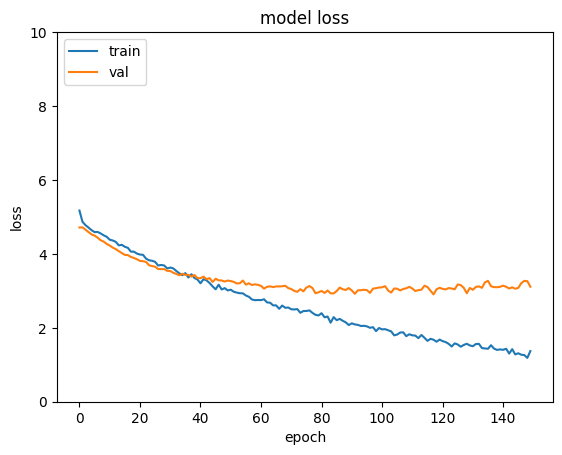

In [35]:
plt.plot(history.history['loss'])
plt.ylim(0,10)
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc="upper left")
plt.show()

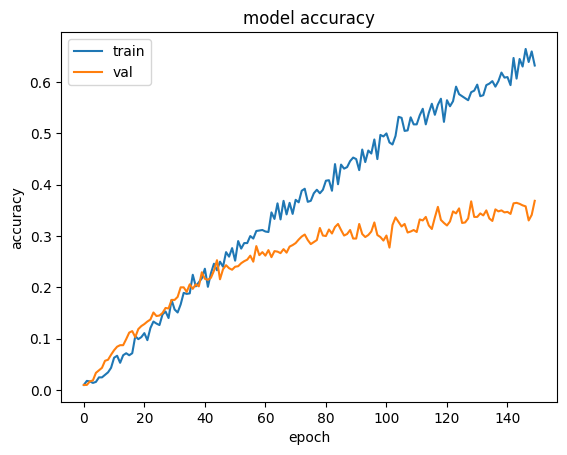

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc="upper left")
plt.show()